### Import module

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

In [3]:
from sklearn.cluster import KMeans

In [4]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from pycaret.regression import *

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### Read Data

In [6]:
train = pd.read_csv('../data/train_df.csv', encoding = 'cp949')
test = pd.read_csv('../data/test_df.csv', encoding = 'cp949')

#X_train = train.drop(['index','INVC_CONT'],axis = 1)
#X_test = test.drop('index',axis = 1)

X_train = train.copy()
X_test = test.copy()
y_train = train['INVC_CONT']

submission = pd.read_csv('../data/sample_submission.csv')

In [7]:
train.shape, test.shape

((32000, 6), (4640, 5))

In [8]:
features = pd.concat([X_train, X_test]).reset_index(drop=True)
features_index = features['index']
features

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3.0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3.0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9.0
3,3,1154500002014200,5011000315087400,식품,농산물,10.0
4,4,1165000021008300,5011000177051200,식품,가공식품,3.0
...,...,...,...,...,...,...
36635,36635,5013000858004400,4725000719072200,식품,농산물,NaN
36636,36636,5013000870018300,2826000106075300,식품,농산물,NaN
36637,36637,5013000897086300,4311100034004300,식품,농산물,NaN
36638,36638,5013000902065100,4145000013011200,식품,농산물,NaN


### data preprocessing

#### kmeans

In [9]:
wss=[]
for k in np.arange(1,10):
    km_k = KMeans(n_clusters=k).fit(features[['SEND_SPG_INNB', 'REC_SPG_INNB']])
    wss.append(km_k.inertia_)

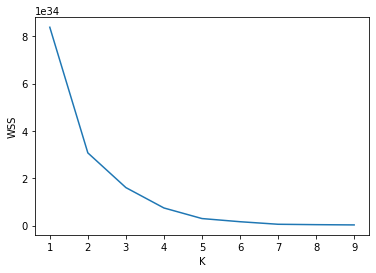

In [10]:
plt.plot(np.arange(1,10),wss)
plt.xlabel('K')
plt.ylabel('WSS')
plt.show()

In [11]:
km = KMeans(n_clusters=5).fit(features[['SEND_SPG_INNB', 'REC_SPG_INNB']])

features['cluster_km']=km.labels_
features['cluster_km']=features['cluster_km'].astype('category')

features.cluster_km.value_counts()

0    16812
2     6555
4     5960
1     5713
3     1600
Name: cluster_km, dtype: int64

#### 평균거래량

In [12]:
# 송하인 기준으로 총 몇개의 택배를 보냈는지 확인하여 이를 피처로 만들어줌 
groupby_SEND_SPG_INNB_sum = features.groupby('SEND_SPG_INNB').sum()['INVC_CONT'].reset_index()
# 이후에 피처로 만들어주기 위한 dic생성
groupby_SEND_SPG_INNB_sum_dix = {x:y for x,y in zip(groupby_SEND_SPG_INNB_sum['SEND_SPG_INNB'], groupby_SEND_SPG_INNB_sum['INVC_CONT'])}
# 피처 생성
features['총물류량'] = features['SEND_SPG_INNB'].apply(lambda x: groupby_SEND_SPG_INNB_sum_dix[x])

In [13]:
# 송하인 기준으로 총 몇명의 수하인에게 택배를 보냈는지 확인하여 이를 피처로 만들어줌 
groupby_SEND_SPG_INNB_count = features.groupby('SEND_SPG_INNB').count()['REC_SPG_INNB'].reset_index()
# 이후에 피처로 만들어주기 위한 dic생성
groupby_SEND_SPG_INNB_count_dix = {x:y for x,y in zip(groupby_SEND_SPG_INNB_count['SEND_SPG_INNB'], groupby_SEND_SPG_INNB_count['REC_SPG_INNB'])}
# 피처 생성
features['거래수하인수'] = features['SEND_SPG_INNB'].apply(lambda x: groupby_SEND_SPG_INNB_count_dix[x])

In [14]:
# 평균 한건당 몇번의 수화물을 보내는지에 대한 피처 생성
features['평균거래량'] = features['총물류량'] / features['거래수하인수']

#### send_mcls_count

In [15]:
features_send_mcls = features.groupby('SEND_SPG_INNB')['DL_GD_MCLS_NM'].agg(**{
    'send_mcls_count':lambda x:x.count()
}).reset_index()

In [16]:
features = pd.merge(features, features_send_mcls, on = 'SEND_SPG_INNB', how = 'left')

#### rec_mcls_count

In [17]:
features_rec_mcls = features.groupby('REC_SPG_INNB')['DL_GD_MCLS_NM'].agg(**{
    'rec_mcls_count':lambda x:x.count()
}).reset_index()

In [18]:
features = pd.merge(features, features_rec_mcls, on = 'REC_SPG_INNB', how = 'left')

In [19]:
features['send_lcls'] = features.apply(lambda x: str(x['SEND_SPG_INNB'])+'_'+str(x['DL_GD_LCLS_NM']), axis=1)

In [20]:
le = LabelEncoder()
le.fit(features['send_lcls'])
le_SEND_LCLS = le.transform(features['send_lcls'])

In [21]:
features_SEND_LCLS = pd.DataFrame(le_SEND_LCLS, columns = ['send_lcls'])

In [22]:
features['send_lcls'] = features_SEND_LCLS

In [23]:
y_features = features['INVC_CONT']
features = features.drop(columns=['index','INVC_CONT'])

In [24]:
# features = pd.get_dummies(features)

### Data Cleansing & Feature Engineering

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36640 entries, 0 to 36639
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEND_SPG_INNB    36640 non-null  int64   
 1   REC_SPG_INNB     36640 non-null  int64   
 2   DL_GD_LCLS_NM    36640 non-null  object  
 3   DL_GD_MCLS_NM    36640 non-null  object  
 4   cluster_km       36640 non-null  category
 5   총물류량             36640 non-null  float64 
 6   거래수하인수           36640 non-null  int64   
 7   평균거래량            36640 non-null  float64 
 8   send_mcls_count  36640 non-null  int64   
 9   rec_mcls_count   36640 non-null  int64   
 10  send_lcls        36640 non-null  int32   
dtypes: category(1), float64(2), int32(1), int64(5), object(2)
memory usage: 3.0+ MB


In [26]:
# 범주형 변수와 수치형 변수를 분리

cat_features = features.select_dtypes(include=['object','category']).columns.to_list()
num_features = features.select_dtypes(exclude=['object','category']).columns.to_list()


In [27]:
cat_features

['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM', 'cluster_km']

In [28]:
num_features = num_features[2:]
num_features

['총물류량', '거래수하인수', '평균거래량', 'send_mcls_count', 'rec_mcls_count', 'send_lcls']

In [29]:
# 수치형 변수를 정규분포에 가깝게 만들기 + 표준화

mmscaler = MinMaxScaler()
features[num_features] = mmscaler.fit_transform(features[num_features])
#features[num_features] = np.log1p(features[num_features])
#features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
#features[num_features] = rsscaler.fit_transform(features[num_features])

features

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,cluster_km,총물류량,거래수하인수,평균거래량,send_mcls_count,rec_mcls_count,send_lcls
0,1129000014045300,5011000220046300,패션의류,상의,3,0.017474,0.015273,0.033960,0.015273,0.032258,0.032396
1,1135000009051200,5011000178037300,생활/건강,반려동물,3,0.008420,0.006605,0.037192,0.006605,0.000000,0.037161
2,1135000030093100,5011000265091400,패션의류,기타패션의류,3,0.001646,0.000206,0.119966,0.000206,0.000000,0.039066
3,1154500002014200,5011000315087400,식품,농산물,3,0.000633,0.000000,0.092282,0.000000,0.354839,0.061220
4,1165000021008300,5011000177051200,식품,가공식품,3,0.000190,0.000000,0.027685,0.000000,0.096774,0.081467
...,...,...,...,...,...,...,...,...,...,...,...
36635,5013000858004400,4725000719072200,식품,농산물,0,0.013612,0.011352,0.035430,0.011352,0.032258,0.964745
36636,5013000870018300,2826000106075300,식품,농산물,2,0.006838,0.004747,0.041527,0.004747,0.000000,0.980229
36637,5013000897086300,4311100034004300,식품,농산물,0,0.003799,0.003922,0.027685,0.003922,0.000000,0.984278
36638,5013000902065100,4145000013011200,식품,농산물,0,0.008990,0.007430,0.035416,0.007430,0.000000,0.985469


In [30]:
features = pd.concat([features_index, features],axis=1)
features = pd.concat([features, y_features],axis=1)

### PCA

In [31]:
# 차원축소 매소드 
from sklearn.decomposition import PCA

def dummy_to_pca(tr, column_name:str) :
    max_seq = 300
    max_d = 15
    col_count = tr.groupby(column_name)[column_name].count()
    if len(col_count) > max_seq:
        tops = col_count.sort_values(ascending=False)[0:max_seq].index
        f =tr.loc[tr[column_name].isin(tops)][['index', column_name]]
    else:
        tops = col_count.index
        f =tr[['index', column_name]]
    f = pd.get_dummies(f, columns=[column_name])  # This method performs One-hot-encoding
    f = f.groupby('index').mean()
    if len(tops) < max_d:
        max_d = len(tops)
    pca = PCA(n_components=max_d)
    pca.fit(f)
    cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
    #print(cumsum)
    num_d = np.argmax(cumsum >= 0.99) + 1 # 분산의 설명량이 99%이상 되는 차원의 수
    if num_d == 1:
        num_d = max_d
    pca = PCA(n_components=num_d)    
    result = pca.fit_transform(f)
    result = pd.DataFrame(result)
    result.columns = [column_name + '_' + str(column) for column in result.columns]
    result.index = f.index
    return result.reset_index()

In [32]:
# PCA를 진행한 데이터 생성
pca = pd.concat([dummy_to_pca(features, 'DL_GD_LCLS_NM').iloc[:,1:], dummy_to_pca(features, 'DL_GD_MCLS_NM').iloc[:,1:]],axis=1)
features = pd.concat([features.drop(columns=['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']), pca], axis=1) 

In [33]:
X_train = features.iloc[:32000]
X_test = features.iloc[32000:]
X_train = X_train.drop(columns = ['index']).reset_index(drop=True)
X_test = X_test.drop(columns = ['index','INVC_CONT']).reset_index(drop=True)

In [ ]:
#X_train['INVC_CONT'] = y_train

### modeling

In [37]:
cell_start_time = time()
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.9,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = 'INVC_CONT', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = True, # GPU가 있으면 사용하세요 (Cat Boost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['INVC_CONT']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            numeric_imputation = 'mean',
            session_id = 2021,
            fold_shuffle = True,
            ignore_low_variance = True,
            combine_rare_levels = True, 
            rare_level_threshold = 0.05,
            remove_multicollinearity = True, 
            multicollinearity_threshold = 0.90
            )
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Description,Value
0,session_id,2021
1,Target,INVC_CONT
2,Original Data,"(32000, 30)"
3,Missing Values,False
4,Numeric Features,29
5,Categorical Features,0
6,Transformed Train Set,"(28800, 29)"
7,Transformed Test Set,"(3200, 29)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


CELL RUN TIME :  16.505330801010132


In [38]:
cell_start_time = time()
top5_models = compare_models(fold = 5, round = 3, sort = 'RMSE', n_select = 5)
cell_end_time = time()
print("CELL RUN TIME : ",cell_end_time - cell_start_time)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.838,22.121,4.686,0.339,0.361,0.350,0.022
ridge,Ridge Regression,1.838,22.153,4.690,0.339,0.361,0.352,0.016
lightgbm,Light Gradient Boosting Machine,1.887,25.238,5.004,0.248,0.369,0.354,3.762
gbr,Gradient Boosting Regressor,1.851,25.580,5.038,0.231,0.360,0.349,2.982
catboost,CatBoost Regressor,1.888,27.592,5.231,0.176,0.368,0.354,3.580
rf,Random Forest Regressor,2.026,29.705,5.436,0.106,0.407,0.386,4.548
xgboost,Extreme Gradient Boosting,1.971,31.689,5.606,0.060,0.386,0.367,0.822
br,Bayesian Ridge,2.515,33.215,5.733,0.024,0.488,0.520,0.038
lr,Linear Regression,2.254,33.845,5.788,0.005,0.422,0.438,0.020
lasso,Lasso Regression,2.254,33.845,5.788,0.005,0.422,0.438,0.504


CELL RUN TIME :  153.9207489490509


In [40]:
#OMP
omp = create_model('omp')
#hyperparameter tuning
omp = tune_model(omp, optimize = 'RMSE', choose_better = True, fold = 5, n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.9261,28.8961,5.3755,0.3339,0.3689,0.3475
1,1.8143,20.8951,4.5711,0.3432,0.3611,0.3505
2,1.8492,22.4400,4.7371,0.4477,0.3563,0.3542
3,1.8311,21.6144,4.6491,0.1541,0.3661,0.3549
4,1.7841,16.8257,4.1019,0.4137,0.3557,0.3511
Mean,1.8409,22.1343,4.6870,0.3385,0.3616,0.3516
SD,0.0477,3.8937,0.4083,0.1016,0.0052,0.0027


In [41]:
#Ridge
ridge = create_model('ridge')
#hyperparameter tuning
ridge = tune_model(ridge, optimize = 'RMSE', choose_better = True, fold = 5, n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.9253,28.8643,5.3725,0.3347,0.3687,0.3480
1,1.8140,20.9156,4.5734,0.3426,0.3613,0.3512
2,1.8496,22.4894,4.7423,0.4464,0.3567,0.3546
3,1.8319,21.5431,4.6415,0.1569,0.3663,0.3559
4,1.7853,16.8450,4.1043,0.4131,0.3565,0.3522
Mean,1.8412,22.1315,4.6868,0.3387,0.3619,0.3524
SD,0.0471,3.8789,0.4068,0.1002,0.0050,0.0027


In [39]:
#LGBM
lgbm = create_model('lightgbm')
#hyperparameter tuning
lgbm = tune_model(lgbm, optimize = 'RMSE', choose_better = True, fold = 5, n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.0663,33.6681,5.8024,0.2239,0.3901,0.3796
1,1.8811,23.9315,4.8920,0.2478,0.3767,0.3613
2,1.9223,23.8812,4.8868,0.4122,0.3703,0.3693
3,1.9013,22.5554,4.7493,0.1173,0.3795,0.3721
4,1.8675,19.5256,4.4188,0.3197,0.3685,0.3640
Mean,1.9277,24.7124,4.9499,0.2642,0.3770,0.3692
SD,0.0717,4.7552,0.4597,0.0984,0.0077,0.0064


In [42]:
#gbr
gbr = create_model('gbr')
#hyperparameter tuning
gbr = tune_model(gbr, optimize = 'RMSE', choose_better = True, fold = 5, n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.9284,29.8856,5.4668,0.3111,0.3645,0.3484
1,1.8420,22.1692,4.7084,0.3032,0.3600,0.3559
2,1.8979,26.2156,5.1201,0.3547,0.3553,0.3572
3,1.8344,21.3651,4.6222,0.1639,0.3629,0.3625
4,1.7967,18.3075,4.2787,0.3621,0.3525,0.3523
Mean,1.8599,23.5886,4.8393,0.2990,0.3590,0.3553
SD,0.0471,4.0349,0.4126,0.0714,0.0045,0.0048


In [43]:
#catboost
catboost = create_model('catboost')
#hyperparameter tuning
catboost = tune_model(catboost, optimize = 'RMSE', choose_better = True, fold = 5, n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.9320,29.7222,5.4518,0.3149,0.3657,0.3513
1,1.8316,23.2733,4.8242,0.2685,0.3604,0.3520
2,1.8624,24.4351,4.9432,0.3985,0.3540,0.3499
3,1.8369,22.2619,4.7182,0.1288,0.3637,0.3587
4,1.7912,18.0198,4.2450,0.3721,0.3536,0.3501
Mean,1.8508,23.5425,4.8365,0.2966,0.3595,0.3524
SD,0.0466,3.7735,0.3883,0.0953,0.0049,0.0032


In [ ]:
#rf
rf = create_model('rf')
#hyperparameter tuning
rf = tune_model(rf, optimize = 'RMSE', choose_better = True, fold = 5, n_iter = 30)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.1736,45.3825,6.7367,0.2408,0.4085,0.3698
1,2.0299,29.9259,5.4705,-0.1105,0.4098,0.3867
2,1.8941,21.3484,4.6204,0.3467,0.3918,0.3780
3,2.1003,31.4820,5.6109,-0.0176,0.4187,0.3933
4,2.1074,33.6159,5.7979,0.3820,0.4127,0.4005
5,1.9522,23.3454,4.8317,0.1299,0.3943,0.3792
6,2.0716,34.5178,5.8752,-0.2567,0.4127,0.4017
7,1.9745,23.5761,4.8555,0.0026,0.4031,0.3843
8,1.9177,25.0371,5.0037,0.3476,0.3970,0.3726
9,1.9192,20.3619,4.5124,-0.0707,0.4014,0.3782


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:17:28
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
models = []
for model in top5_models:
    models.append(tune_model(model, optimize = 'RMSE', choose_better = True, n_iter = 30))

In [ ]:
voting = blend_models(models, optimize = 'RMSE')
voting = tune_model(voting,
                 optimize = 'RMSE',
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)

In [ ]:
# test 데이터 예측
pred = voting.predict(X_test)

### submission

In [ ]:
submission['INVC_CONT'] = pred

In [ ]:
submission.to_csv('../submissions/pycaret_voting_211214.csv',index = False)